Библиотеки

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#for test
import sklearn 
from pylab import rcParams


#для отображения всех данных из pd (без ...)
pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Загрузка данных

In [2]:
START_DATA = pd.read_csv ('half_dataset.zip', header=[0, 1])

Просто смотрю на формат данных

In [9]:
START_DATA.shape
START_DATA.columns
#START_DATA.tail()
#print(START_DATA.dtypes)

MultiIndex([( 'Unnamed: 0_level_0',   'Unnamed: 0_level_1'),
            (   'timestamp_second',   'Unnamed: 0_level_1'),
            (        'bid_price_0',              'nunique'),
            (        'bid_price_0',                 'mean'),
            (        'bid_price_0',               'median'),
            (        'bid_price_0',                  'std'),
            (        'bid_price_0',                  'min'),
            (        'bid_price_0',                  'max'),
            (        'bid_price_0',                'first'),
            (        'bid_price_0',                 'last'),
            ...
            ('sell_trade_quantity',                  'sum'),
            ('sell_trade_quantity',                 'mean'),
            ('sell_trade_quantity',               'median'),
            ('sell_trade_quantity',                  'std'),
            ('sell_trade_quantity',                  'min'),
            ('sell_trade_quantity',                  'max'),
        

In [10]:
#basic_data = START_DATA.bid_price_0["mean"].dropna()

In [11]:
START_DATA.bid_price_0["mean"].head()

0    44.183379
1    44.190000
2    44.187467
3    44.181038
4    44.213095
Name: mean, dtype: float64

Строю графики для bid, ask

<AxesSubplot:title={'center':'BID_0'}, ylabel='Цена, $'>

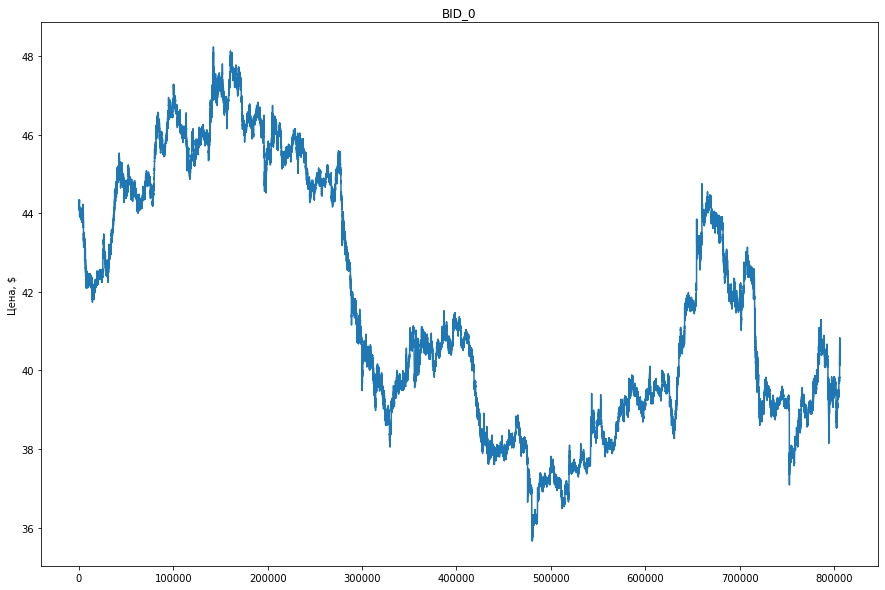

In [12]:
START_DATA.bid_price_0["mean"].plot(title = 'BID_0', xlabel = '', ylabel = 'Цена, $', figsize = (15, 10))

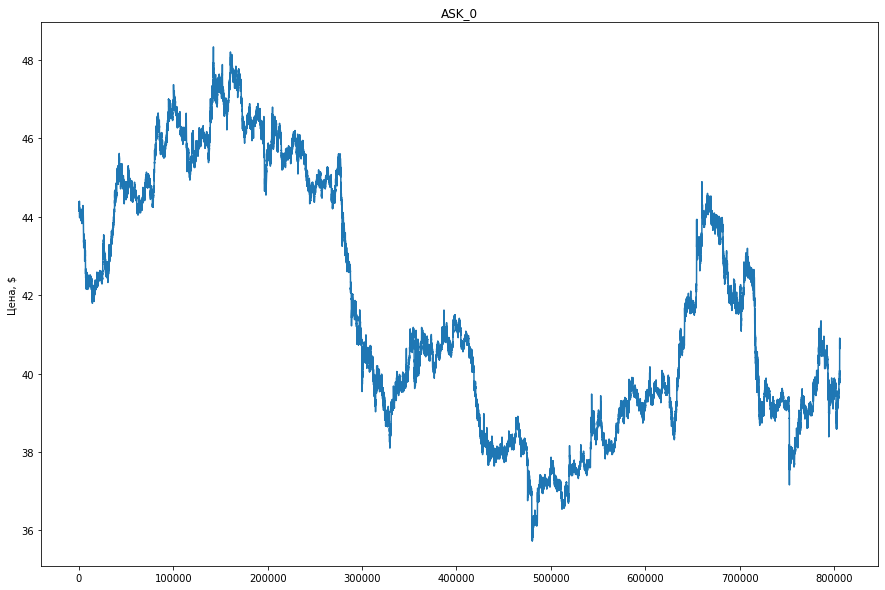

In [14]:
plt = START_DATA.ask_price_0["mean"].plot(title = 'ASK_0', xlabel = '', ylabel = 'Цена, $', figsize = (15, 10))

<AxesSubplot:ylabel='Цена, $'>

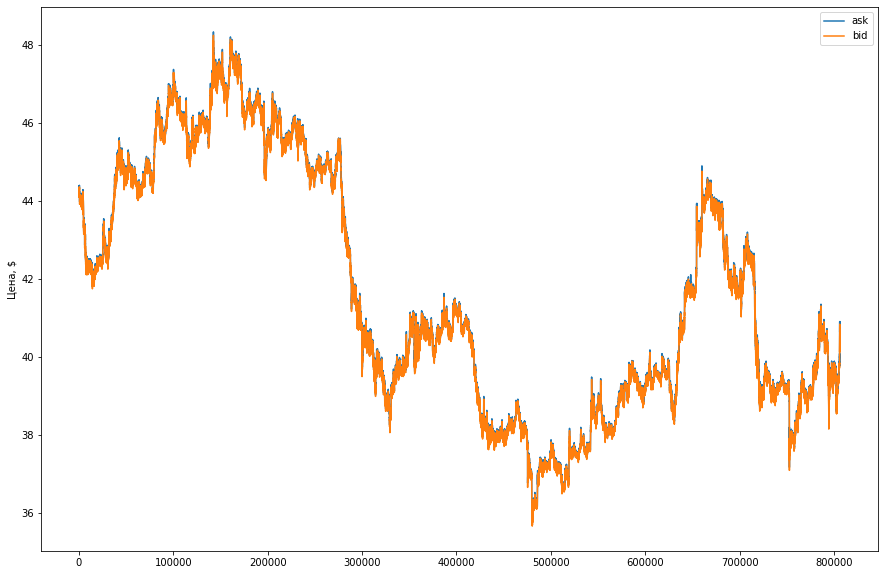

In [13]:
Ask_Bid_Graphs = pd.DataFrame(index = START_DATA.index)
Ask_Bid_Graphs['ask'] = START_DATA.ask_price_0["mean"]
Ask_Bid_Graphs['bid'] = START_DATA.bid_price_0["mean"]
Ask_Bid_Graphs.plot(ylabel = 'Цена, $', figsize = (15, 10))


Начало разработки моделей предсказания

Беру только нужные для предсказания поля из всех данных

In [15]:
Bid_mean_DataFrame = pd.DataFrame(data = {'mean_bid': START_DATA.bid_price_0["mean"], 'seconds':START_DATA.timestamp_second['Unnamed: 0_level_1']} )
Bid_mean_DataFrame = Bid_mean_DataFrame.set_index('seconds')
Bid_mean_DataFrame.tail

<bound method NDFrame.tail of           mean_bid
seconds           
0        44.183379
1        44.190000
2        44.187467
3        44.181038
4        44.213095
...            ...
805991   40.635062
805992   40.634050
805993   40.630763
805994   40.619000
805995   40.625260

[805996 rows x 1 columns]>

Разделяю данные на тренировочные и тестовы

In [104]:
from sklearn.metrics import mean_absolute_error

Кросс валидация (MAE метрика)

In [109]:
def cross_validation(data: pd.DataFrame, model, metrics, train_lenght: int=0, step: int=1) -> float:
    values_for_metric = {"test":[], "model":[]}
    len_of_data = len(data['mean_bid'])
    if not train_lenght:
        train_lenght = int((len_of_data * 0.8)//1)
    for n in range(train_lenght + 60, len_of_data, step):
        train_data = data.iloc[: n - 60]
        values_for_metric["model"].append(model(train_data))
        values_for_metric["test"].append(data['mean_bid'][n])
    plt.figure(figsize=(20,10))
    plt.grid()
    plt.plot(values_for_metric["model"], label='Model')
    plt.plot(values_for_metric["test"], label='Test')
    plt.legend()
    plt.show()
    return metrics(values_for_metric["test"], values_for_metric["model"])

In [106]:
length_of_train = len(Bid_mean_DataFrame) - 60 
train_data = Bid_mean_DataFrame[0:length_of_train] 
test_data = Bid_mean_DataFrame[length_of_train:]

Наивная модель

In [110]:
def naive_model(data: pd.DataFrame) -> float:
    return data['mean_bid'].iloc[-1]

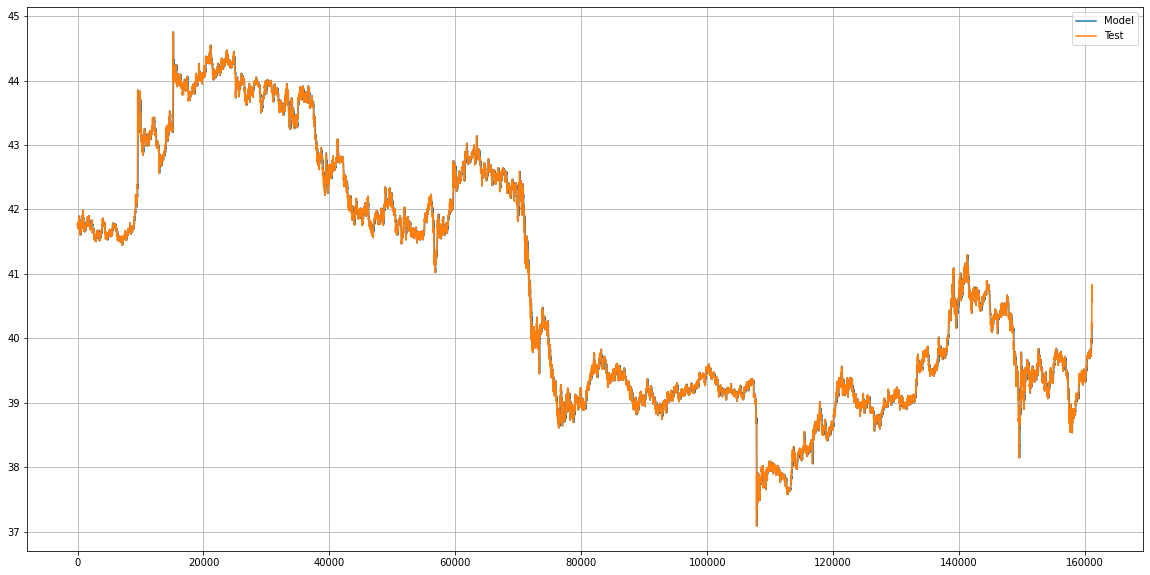

0.058660891464135445

In [111]:
cross_validation(train_data, naive_model, mean_absolute_error, step = 1)

Средняя модель

In [112]:
def mean_model(data: pd.DataFrame) -> float:
    return data['mean_bid'].mean(0)

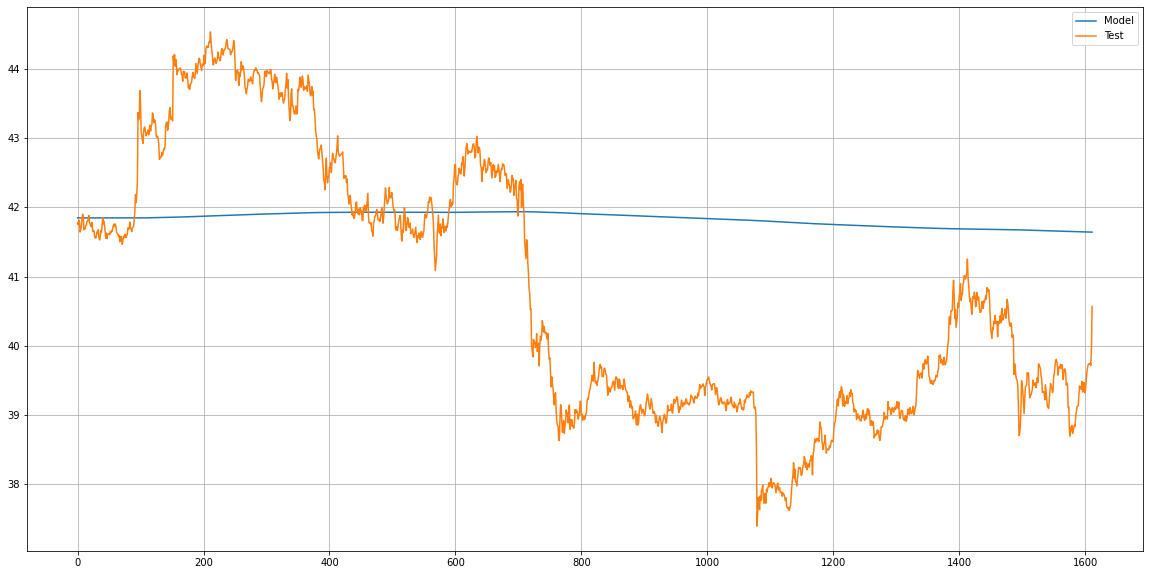

1.8103171985735418

In [113]:
cross_validation(train_data, mean_model, mean_absolute_error, step = 100)

Сезонный метод

In [114]:
def seasonal_model(data: pd.DataFrame, season_period: int = 100) -> float:
    #if season_period > len(data - 1):
    #    print('you are naive!')
    #    return data['mean_bid'].iloc[-1]
    return data['mean_bid'].iloc[-season_period]

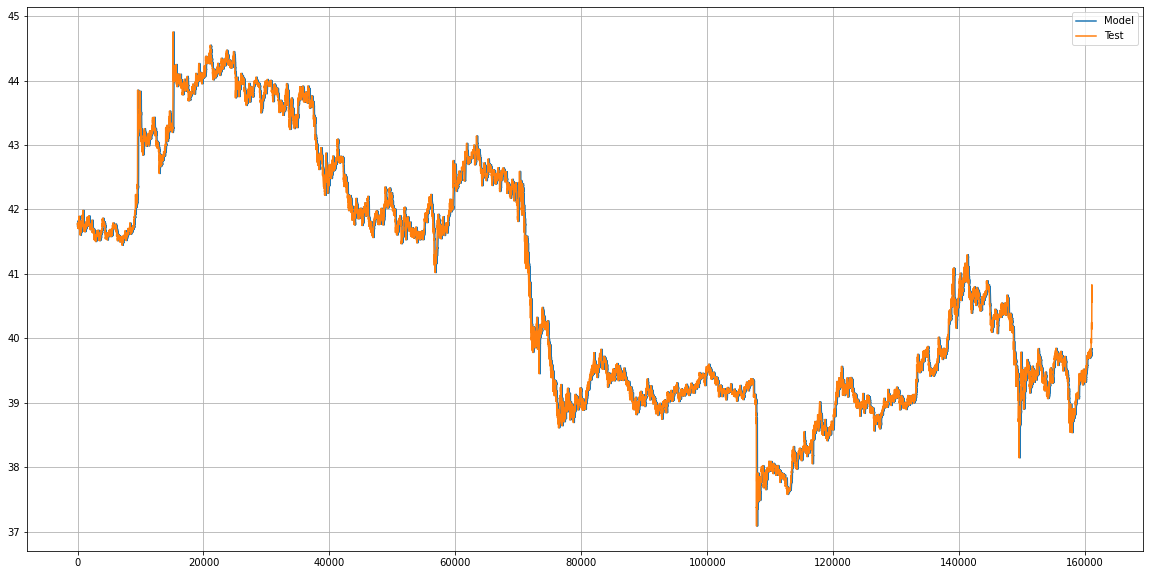

0.09893885614480231

In [115]:
cross_validation(train_data, seasonal_model, mean_absolute_error, step = 1)

just a test

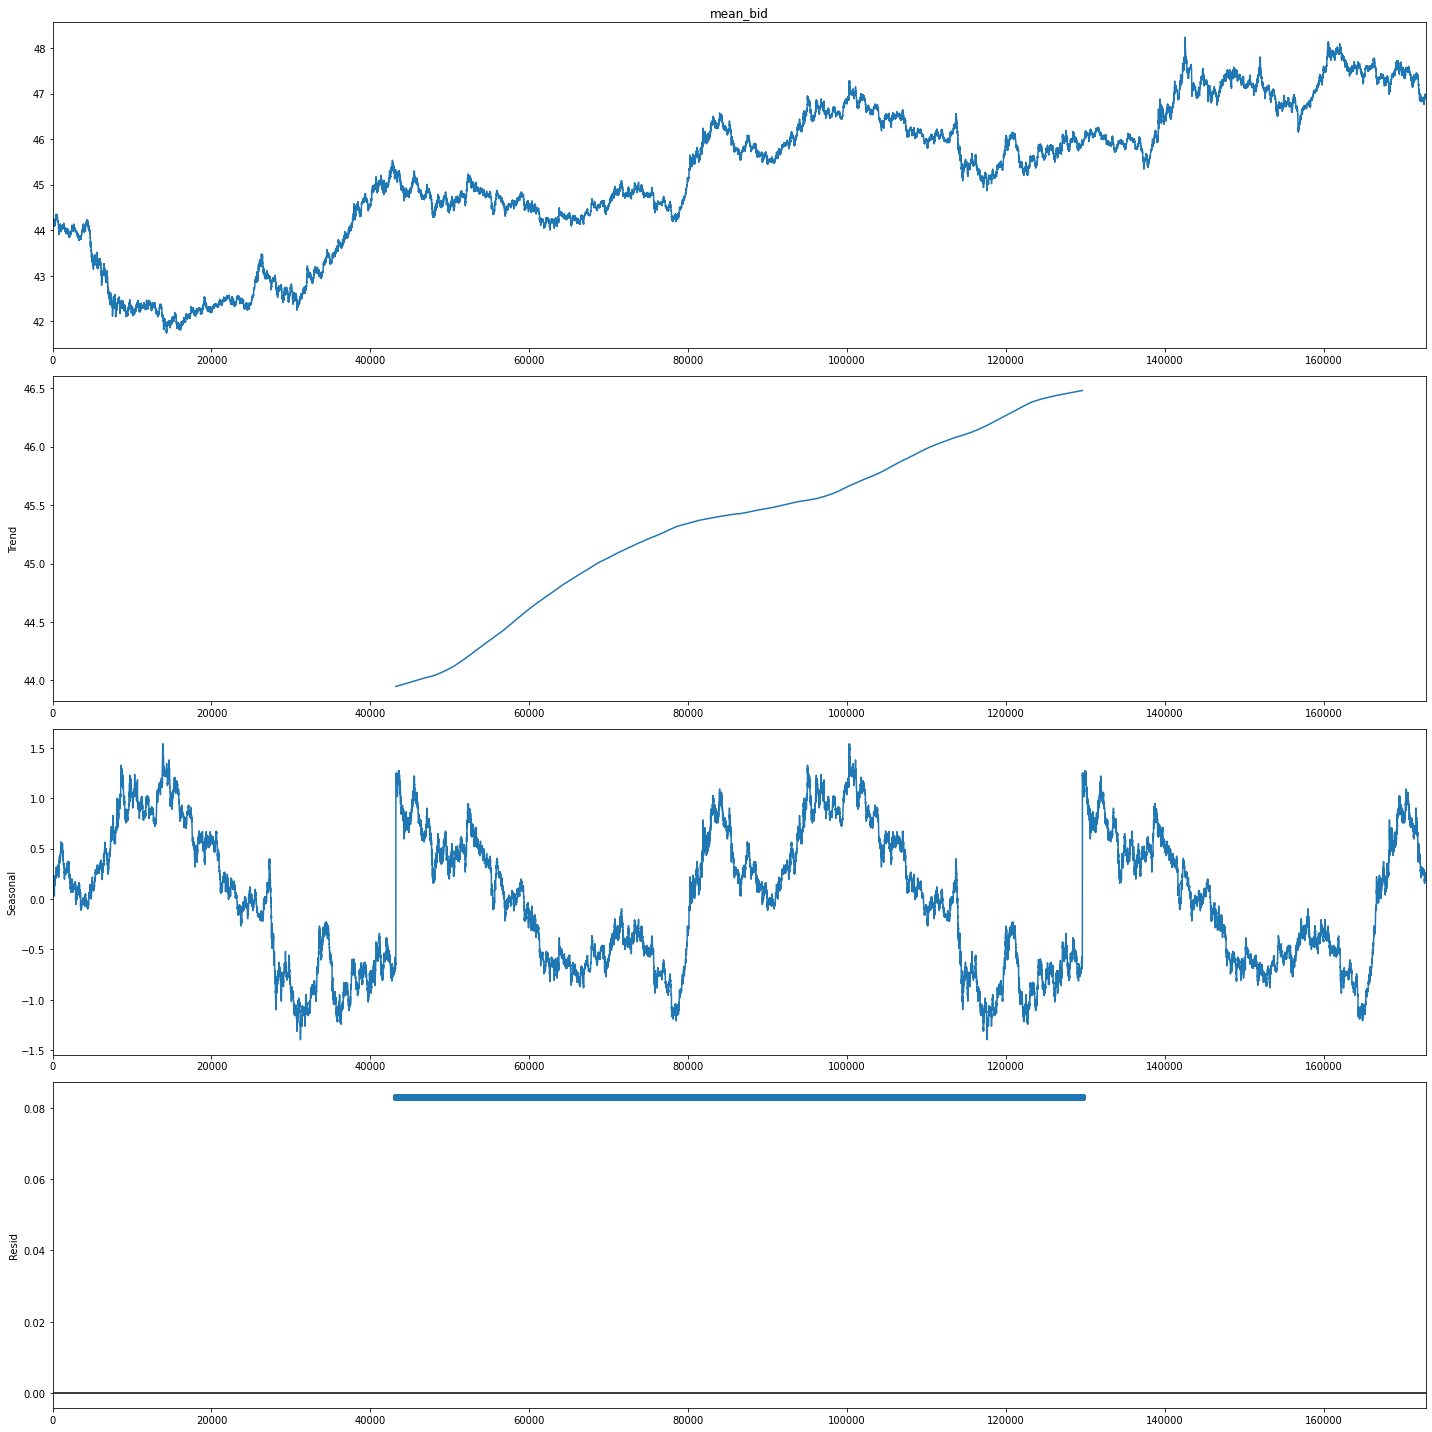

In [111]:
import statsmodels as sm
rcParams['figure.figsize'] = 20,20
fr = 60*60*24
decomposition = sm.tsa.seasonal.seasonal_decompose(train_data.mean_bid,
                                period = fr,
                                model='additive' ) # additive seasonal index
fig = decomposition.plot()
plt.show()